In [13]:
# General imports
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import collections
import os
from time import time

# Data Science
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Natural Language processing
import nltk

# Algorithms / estimators
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

# Metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Process
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

# Corpus
from documentModel import DocumentModel as DM
from export_results import *

from scipy import stats

def is_significant(model_1, model_2, significance = 0.05):
    
    p_value = stats.wilcoxon(recall_avg[model_1], recall_avg[model_2])[1]
    print(p_value)
    if p_value < significance:
        print("It is statically significant")
    else:    
        print("It is NOT statically significant")

def save_image(image, url='../images/', name = 'default'):
    image.savefig(url + name)
    
def plot_image(x, y, title="title", ylim = [0, 1.02], xlim = [2, 50.5], 
               colors="rgbmyc", models=None, name="name", labels=[]):
    colors = colors
    models = models
    plt.figure(figsize=(12,8))
    plt.ylim(ylim)
    plt.xlim(xlim)
#    plt.title(title)
    for model, color in zip(models, colors):
        plt.plot(x, y[model[0]], color=color, label=model[0])
        plt.scatter(x, y[model[0]], color=color, s=50)
        #plt.fill_between(costs, np.asarray(recall_avg[model[0]]) - recall_std[model[0]], 
        #             np.asarray(recall_avg[model[0]]) + recall_std[model[0]], 
        #             alpha=0.1, color=color)
    
    plt.style.use('paper.mplstyle')
    plt.xticks(x, labels, rotation='vertical')
    plt.legend(loc='better', prop={'size':20})

    save_image(plt,'../images/', name)
    plt.show()

# Business Rule Classification

In [3]:
stop_words = ['a', 'bajo', 'en', 'para','un', 'la', 'el', 'los', 'las', 'su', 'sus', 'través', 'al','con', \
             'más', 'muy', 'cual', 'poco', 'que']

print("Transforming annotated files into training datasets...")
dm = DM()
fito_dataset = dm.get_sentences(0)
X, y = fito_dataset["data"], fito_dataset["target"]

print("OK")

Transforming annotated files into training datasets...
OK


## NLP Exploration

In [4]:
rule_data = pd.DataFrame({"rule": X, "tag": y})
permissions = rule_data[rule_data["tag"] == 0]
prohibitions = rule_data[rule_data["tag"] == 1]

In [5]:
permissions.head()

,rule,tag
0,Aplicar sobre el suelo en pequeños montones o ...,0
3,"Aplicar en pulverización normal, variando la d...",0
4,En la etiqueta deberán figurar las instruccion...,0
9,"Aplicar en pulverización normal, dependiendo d...",0
14,Aplicar en pulverización normal,0


In [6]:
prohibitions.head()

,rule,tag
1,Evitar que el producto caiga sobre las plantas...,1
2,Advertir en la etiqueta que es peligroso para ...,1
5,No mezclar con aceites ni productos de reacció...,1
6,No aplicar aceites minerales durante los 21 dí...,1
7,No aplicar en cultivos cuyos frutos sean desti...,1


## Experiments

In [7]:
labels = ["1:1","1:2","1:4","1:6","1:10","1:25", "1:50", "1:100"]
# like the ShuffleSplit strategy, stratified random splits do not guarantee 
#that all folds will be different, although this is still very likely for sizeable datasets
sss = StratifiedShuffleSplit(y, n_iter = 5, test_size=0.2, random_state=0)
costs = np.array([2, 3, 4, 6, 10, 25, 50, 100])
axis_costs = np.arange(1,9,1)
cxlim = [0.8, 8.15]

In [8]:
extractor = TfidfVectorizer(use_idf=True, stop_words=stop_words)
extractor.fit(X)

def init():
    recall_avg = {}
    recall_std = {}
    precision_avg = {}
    precision_std = {}
    
    for model in models:
        recall_avg[model[0]] = []
        recall_std[model[0]] = []
        precision_avg[model[0]] = []
        precision_std[model[0]] = []
        
    return recall_avg, recall_std, precision_avg, precision_std

In [9]:
models = [("Random Forest", RandomForestClassifier),
          ("Naive Bayes", MultinomialNB),
          ("SVM", SVC),
          ("Always Prohibition", DummyClassifier),
          ]

recall_avg, recall_std, precision_avg, precision_std = init()

for estimator in models:
    for cost in costs:
        if estimator[0] == "Naive Bayes":
            model = estimator[1](class_prior=[1/cost, (cost-1)/cost], fit_prior= False)
        elif estimator[0] == "Random Forest":
            model = estimator[1](class_weight={1:cost-1}, n_estimators = 20)
        elif estimator[0] == "SVM":
            model = estimator[1](class_weight={1:cost-1}, kernel = "linear", C = 0.1)
        elif estimator[0] == "Always Prohibition":
            model = estimator[1](strategy = "constant", random_state = 2016, constant=1)
        else:
            model = estimator[1](class_weight={1:cost-1})
        precisions = []
        recalls = []
        for train_index, test_index in sss:
            X_train, X_test = extractor.transform(X)[train_index], extractor.transform(X)[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            precisions.append(precision_score(y_test, model.predict(X_test), pos_label=1))
            recalls.append(recall_score(y_test, model.predict(X_test), pos_label=1))
        recall_avg[estimator[0]].append(np.average(recalls))
        recall_std[estimator[0]].append(np.std(recalls))
        precision_avg[estimator[0]].append(np.average(precisions))
        precision_std[estimator[0]].append(np.std(precisions))

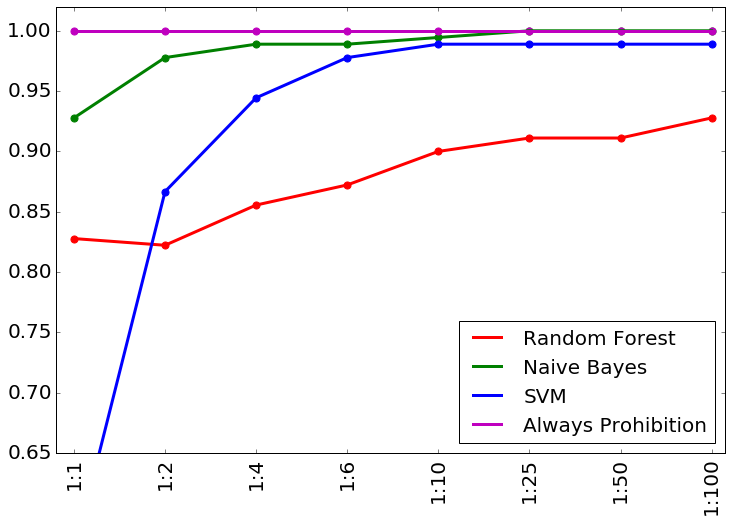

In [14]:
plot_image(axis_costs, recall_avg, title="RECALL", ylim = [0.65, 1.02], 
           xlim = cxlim, colors="rgbmyc", models=models, name="recall", labels=labels)

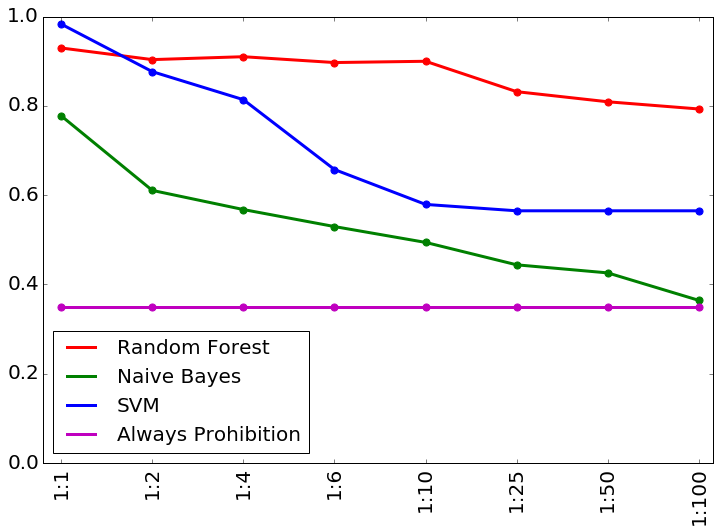

In [15]:
plot_image(axis_costs, precision_avg, title="PRECISION", ylim = [0, 1], 
           xlim = cxlim, colors="rgbmyc", models=models, name="precision", labels = labels)

## Stemming

In [16]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

In [21]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = SnowballStemmer(language="spanish")
    
    def __call__(self, doc):
        return [self.wnl.stem(t) for t in word_tokenize(doc)]
    
def init(extractors, models):
    recall_avg = {}
    recall_std = {}
    precision_avg = {}
    precision_std = {}
    vocabulary_sizes = {}
    for model in models:
        for extractor in extractors:
            name = extractor[0]
            recall_avg[name] = []
            recall_std[name] = []
            precision_avg[name] = []
            precision_std[name] = []
            vocabulary_sizes[extractor[0]] = []
        
    return recall_avg, recall_std, precision_avg, precision_std, vocabulary_sizes

In [22]:
extractors = [("Not Stemming", TfidfVectorizer(tokenizer=None, use_idf=True, stop_words=stop_words)),
              ("Stemming", TfidfVectorizer(tokenizer=LemmaTokenizer(), use_idf=True, stop_words=stop_words))]

recall_avg, recall_std, precision_avg, \
    precision_std, vocabulary_sizes = init(extractors, models)
    
vocabularies = {}    

for i, extractor in enumerate(extractors):
    extractor[1].fit(X)
    print(extractor[0] + " " + str(len(extractor[1].vocabulary_)))
    vocabularies[extractor[0]] = extractor[1].vocabulary_
    for cost in costs:
        model = MultinomialNB(class_prior=[1/cost, (cost-1)/cost], fit_prior= False)
        precisions = []
        recalls = []
        for train_index, test_index in sss:
            X_train, X_test = extractor[1].transform(X)[train_index], extractor[1].transform(X)[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            precisions.append(precision_score(y_test, model.predict(X_test), pos_label=1))
            recalls.append(recall_score(y_test, model.predict(X_test), pos_label=1))
        recall_avg[extractor[0]].append(np.average(recalls))
        recall_std[extractor[0]].append(np.std(recalls))
        precision_avg[extractor[0]].append(np.average(precisions))
        precision_std[extractor[0]].append(np.std(precisions))

Not Stemming 1071
Stemming 880


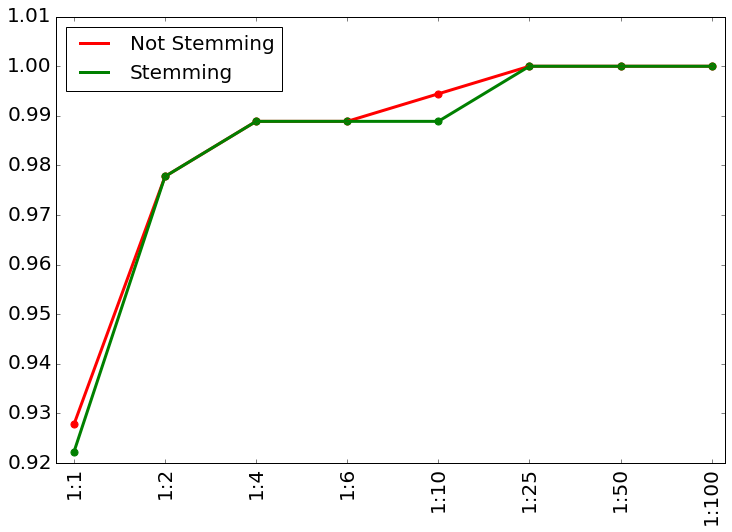

In [23]:
plot_image(axis_costs, recall_avg, title="RECALL", ylim = [0.92, 1.01], 
           xlim = cxlim, colors="rg", models=extractors, name="recall_stemming", labels = labels)

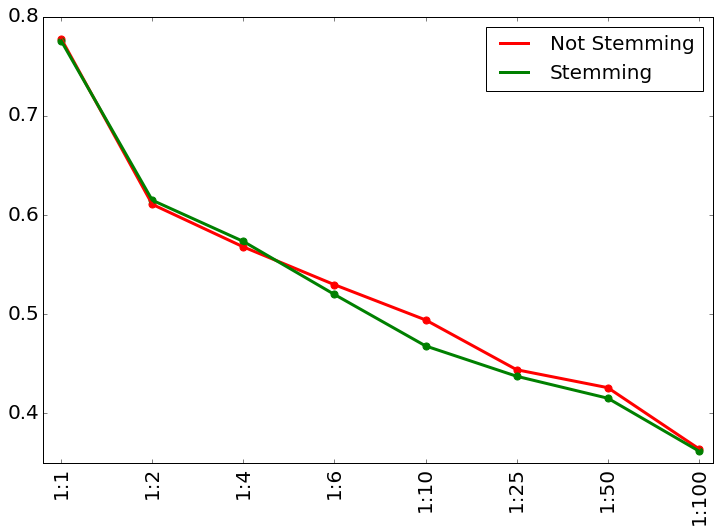

In [24]:
plot_image(axis_costs, precision_avg, title="PRECISION", ylim = [0.35, 0.8], 
           xlim = cxlim, colors="rg", models=extractors, name="precision_stemming", labels = labels)

## Word sequences

In [25]:
extractors = [("unigrams", TfidfVectorizer(use_idf=True, stop_words=stop_words)),
              ("n-grams(1..2)", TfidfVectorizer(ngram_range=(1, 2), use_idf=True, stop_words=stop_words)),
             ("n-grams(2..2)", TfidfVectorizer(ngram_range=(2, 2), use_idf=True, stop_words=stop_words)),
             ]

recall_avg, recall_std, precision_avg, \
    precision_std, vocabulary_sizes = init(extractors, models)

for i, extractor in enumerate(extractors):
    extractor[1].fit(X)
    print(extractor[0] + " " + str(len(extractor[1].vocabulary_)))
    vocabulary_sizes[extractor[0]] = len(extractor[1].vocabulary_)
    for cost in costs:
        model = MultinomialNB(class_prior=[1/cost, (cost-1)/cost], fit_prior= False)
        precisions = []
        recalls = []
        for train_index, test_index in sss:
            X_train, X_test = extractor[1].transform(X)[train_index], extractor[1].transform(X)[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            precisions.append(precision_score(y_test, model.predict(X_test), pos_label=1))
            recalls.append(recall_score(y_test, model.predict(X_test), pos_label=1))
        recall_avg[extractor[0]].append(np.average(recalls))
        recall_std[extractor[0]].append(np.std(recalls))
        precision_avg[extractor[0]].append(np.average(precisions))
        precision_std[extractor[0]].append(np.std(precisions))

unigrams 1071
n-grams(1..2) 3327
n-grams(2..2) 2256


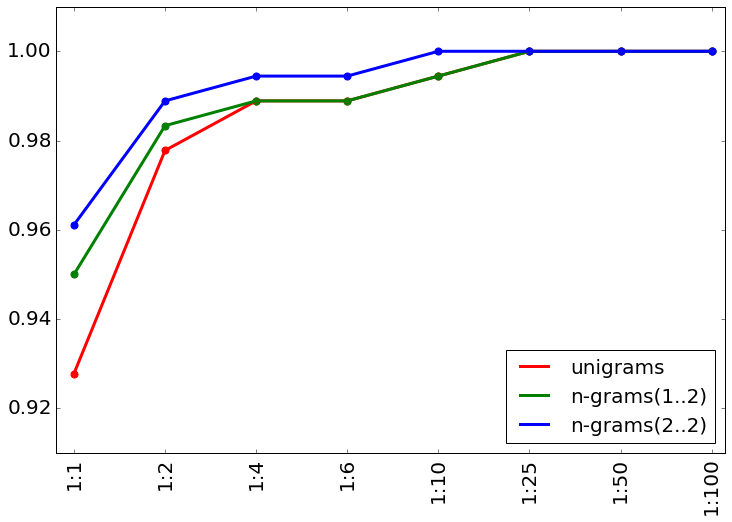

In [26]:
plot_image(axis_costs, recall_avg, title="RECALL", ylim = [0.91, 1.01], 
           xlim = cxlim, colors="rgb", models=extractors, name="recall_n-gram", labels = labels)

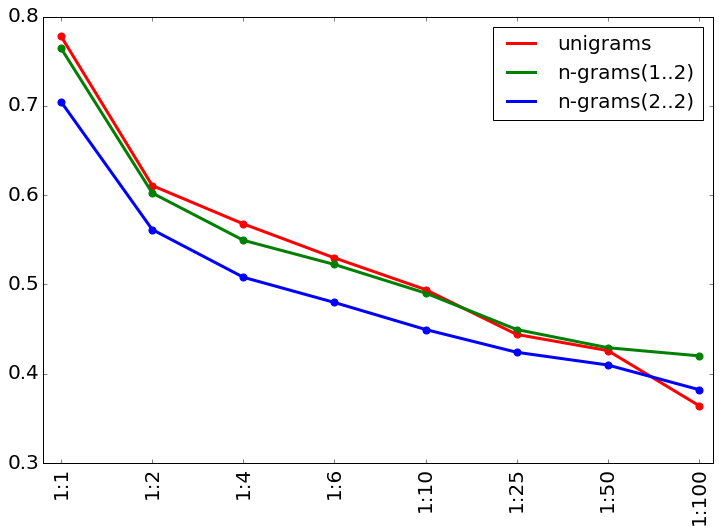

In [27]:
plot_image(axis_costs, precision_avg, title="PRECISION", ylim = [0.3, 0.8], 
           xlim = cxlim, colors="rgb", models=extractors, name="precision_n-gram", labels = labels)